## This notebook contains  a test installation and text generation with the Falcon-7B LLM

It is not really relevant for the DS project because the right message generation can be found in Create_exercise_for_user_with_LLM.ipynb.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from typing import Tuple, List
import time

#Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install einops
!pip install bitsandbytes
!pip install transformers --upgrade
#!pip install torch --upgrade
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.29.2
    Uninstalling transformers-4.29.2:
      Successfully uninstalled transformers-4.29.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.12.0
    Uninstalling accelerate-0.12.0:
      Successfully uninstalled accelerate-0.12.0


In [3]:
import einops
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

In [4]:
import sys
print("Python version")
print (sys.version)
print(transformers.__version__)

Python version
3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
4.30.2


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

using device: cuda


Create functions for checking memory usage at inference

In [6]:
def measure_perf(
    prompt: str, model: AutoModelForCausalLM, tokenizer: AutoTokenizer
) -> Tuple[float, float, torch.Tensor]:
    """
    Measures memory consumption and inference execution time for a given model and prompt.

    Args:
        prompt: Text to be used as input for the model.
        model: Pretrained model used for inference.
        tokenizer: Pretrained tokenizer used to encode the prompt.

    Returns:
        Peak memory consumption in GB, execution time in seconds, and output tensor from the model.
    """
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    start_time = time.time()

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(input_ids, max_length=100)

    end_time = time.time()

    peak_mem = torch.cuda.max_memory_allocated()
    peak_mem_consumption = peak_mem / 1e9  # convert bytes to GB

    exec_time = end_time - start_time

    return peak_mem_consumption, exec_time, outputs

In [7]:
def plot_results(
    mem_consumptions: List[float], execution_times: List[float], dir: str = ""
) -> None:
    """
    Plots memory consumption and execution times.

    Args:
        mem_consumptions: List of memory consumption data in GB.
        execution_times: List of execution time data.
        dir: Destination dir for the plot.
    """
    #os.makedirs(dir, exist_ok=True)

    fig, ax1 = plt.subplots()

    color = "tab:red"
    ax1.set_xlabel("Runs")
    ax1.set_ylabel("GPU Memory Consumption (GB)", color=color)
    ax1.plot(mem_consumptions, color=color)
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.yaxis.get_major_formatter().set_useOffset(False)

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.set_ylabel("Execution time (s)", color=color)
    ax2.plot(execution_times, color=color)
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.yaxis.get_major_formatter().set_useOffset(False)

    fig.tight_layout()
    plt.title("GPU Memory Consumption and Execution Time for Each Run")
    fig.subplots_adjust(top=0.88)
    plt.savefig(f"{dir}/falcon_memory_time.png")

Download the LLM from Huggingface

In [8]:
model_path = "tiiuae/falcon-7b-instruct"
config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    config=config,
    trust_remote_code=True,
    load_in_8bit=True,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_path)

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modelling_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loade


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/lib/x86_64-linux-gnu'), PosixPath('/usr/local/cuda/lib')}
  warn(msg)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generate some test outputs

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Write two short fitness activities that help the user to reduce back pain.
1. Plank exercise: Start by getting into a push-up position on the floor, holding your body in a straight line from your head to your heels. Hold this position for 30 seconds, then release and let your body relax. Repeat 3 times.

2. Cat-cow stretch: Lie on your back with your arms and legs straight. Inhale as you gently arch your back,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Write two short physical activities that help the user to reduce back pain.
1. Cat-cow stretch: Start by lying on your back with your arms and legs straight. Inhale as you gently arch your back, tucking your chin towards your chest. Hold the position for a few seconds, then release and let your body relax. Repeat several times. 2. Superman stretch: Lie on your stomach with your arms extended in front of you. Inhale as you lift your


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Write two short activities that help the user to stay physically active.Write two short physical activities that help the user to lower high blood pressure
1. Walking or light jogging for at least 30 minutes a day.2. Doing 10 minutes of stretching exercises daily.<|endoftext|>
Give some examples for physical activities that help the user to lower high blood pressure
Some examples of physical activities that can help lower high blood pressure include: walking, jogging, cycling, swimming, yoga, and strength training.<|endoftext|>


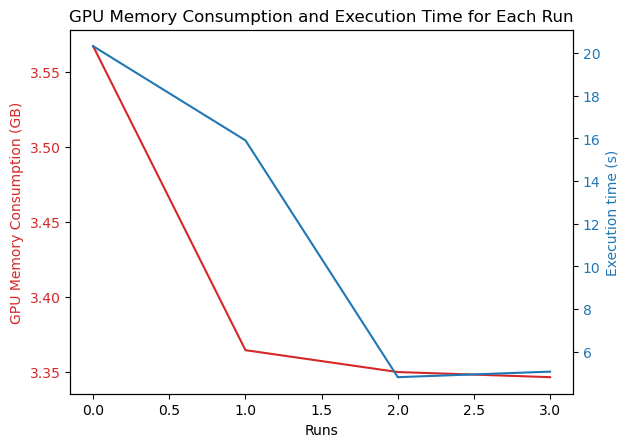

In [9]:
prompts = [
        "Write two short fitness activities that help the user to reduce back pain.",
        "Write two short physical activities that help the user to reduce back pain.",
        "Write two short activities that help the user to stay physically active."
        "Write two short physical activities that help the user to lower high blood pressure",
        "Give some examples for physical activities that help the user to lower high blood pressure",

    ]
mem_consumptions = []
execution_times = []

for i in range(len(prompts)):
    mem_consumption, exec_time, outputs = measure_perf(prompts[i], model, tokenizer)
    mem_consumptions.append(mem_consumption)
    execution_times.append(exec_time)
    print(tokenizer.decode(outputs[0]))

plot_results(mem_consumptions, execution_times)

**The memory usage of under 4GB VRAM is low enough for modern smartphones like the Samsung Galaxy S22 (4GB VRAM)**